### Installations

In [ ]:
!pip install --upgrade pip
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install scikit-learn
!pip install 
!pip install html5lib
!pip install bs4
!pip install tqdm

# Data Collection

In [3]:
# Importing required libraries

# Standard Data Science libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sklearn
import seaborn as sns
import scipy.stats as stats
import sys
import time
import os
import random
%matplotlib inline

# Library for interacting with SQLite databases
import sqlite3

# Web scraping
from bs4 import BeautifulSoup
# Adding bs4 module for type hints
from bs4 import element, Tag, NavigableString, ResultSet
import requests
# Parsing XML and HTML documents (used by BeautifulSoup internally)
import lxml

# Library for handling SSL certificates (used for secure HTTPS requests)
import ssl
# Disables SSL verification for secure requests
ssl._create_default_https_context = ssl._create_unverified_context

# Library for parsing and evaluating Python literal structures (e.g., strings, lists, dictionaries)
import ast

# Library for typing hints in Python code
from typing import List, Tuple, Union

# Library for progress bars in Python
from tqdm import tqdm


In [4]:
def fetch_webpage(url:str) -> requests.Response|None:
    """
    Fetch the content of a webpage
    
    Retrieves the HTML content from the specified URL
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response
    except requests.RequestException as e:
        print(f"Error fetching webpage: {e}")
        return None

def first_letter(word:str) -> str:
    return word[0]

def has_duplicates(input_list: list[str]|list[tuple[str, str]]) -> bool:
    """
    Checks if there are duplicates in the given list.

    Args:
        input_list (list): The list to check.

    Returns:
        bool: True if there are duplicates, False otherwise.
    """
    seen = set()
    for item in input_list:
        if item in seen:
            return True  # Duplicate found
        seen.add(item)
    return False  # No duplicates found

def number_duplicates(input_list: list[str]) -> list:
    """
    Adds numeric suffixes to duplicate items in a list.

    Args:
        input_list (list[str]): The list to process.

    Returns:
        list: A new list with duplicates suffixed by their occurrence count.
    """
    seen_counts = {}
    result = []
    
    for item in input_list:
        if item in seen_counts:
            # Increment the count for this duplicate
            seen_counts[item] += 1
            result.append(f"{item} - {seen_counts[item]}")
        else:
            # First occurrence of this item
            seen_counts[item] = 1
            result.append(f"{item}" if seen_counts[item] == 1 else f"{item} - {seen_counts[item]}")
    
    return result

def remove_duplicates_preserve_order(input_list: list[str]) -> list[str]:
    """
    Removes duplicates from a list while preserving the original order.

    Args:
        input_list (list): The list from which duplicates are to be removed.

    Returns:
        list: A new list with duplicates removed, maintaining the original order.
    """
    seen = set()
    return [item for item in input_list if item not in seen and not seen.add(item)]

def shorten_title(title: str) -> str:
    title_list = title.split()
    acronyms = list(map(first_letter, title_list))
    if len(title_list) > 2:
        return "".join(acronyms)[:-3]
    else:
        return "".join(acronyms)

def extract_table_headers(thead: element.Tag) -> List[Tuple[str, str]]:

    """
    Extracts headers from a thead element into pairs of (over-header, header).
    If no over-header exists, the over-header is an empty string.
    
    Parameters:
        thead (Tag): A BeautifulSoup Tag representing the <thead> element.
    
    Returns:
        List[Tuple[str, str]]: A list of tuples containing (over-header, header).
    """
    headers = []
    over_headers = []

    # First row: extract over-headers
    over_header_row = thead.find("tr", class_="over_header")
    if over_header_row:
        for th in over_header_row.find_all("th"):
            colspan = int(th.get("colspan", 1))
            over_header = th.get("data-stat", "").replace("header_", "") or ""
            over_headers.extend([over_header] * colspan)

    # Second row: extract individual headers
    header_row = thead.find_all("tr")[-1]  # Last row of <thead>
    for idx, th in enumerate(header_row.find_all("th")):
        header = th.text.strip()
        over_header = over_headers[idx] if idx < len(over_headers) else ""
        headers.append((over_header.title(), header))

    return headers

def parse_webpage(response: requests.Response) -> ResultSet[Tag]:
    """
    Parse the webpage using BeautifulSoup
    
    Converts the webpage response into a parseable soup object
    """
    if response:
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup.findAll('div', {"class": "table_wrapper tabbed"})
    return None

def extract_headers(table_header_section: Tag) -> Union[List[Tuple[str, str]], List[str]]:
    """
    Extract headers from a table header section
    
    Handles both single and multi-level headers
    """
    header_rows = table_header_section.find_all("tr")
    
    if len(header_rows) > 1:
        # Multi-level headers
        return extract_table_headers(table_header_section)
    else:
        # Single-level headers
        return [header.text.strip() for header in header_rows[0].find_all("th")]

def extract_table_data(table_body_sections: List[Tag]) -> List[List[str]]:
    """
    Extract data rows from table body sections
    
    Collects text data from table rows
    """
    table_data_rows = []
    for table_body in table_body_sections:
        for row in table_body.children:
            if isinstance(row, element.Tag):
                table_data_rows.append([data_point.text for data_point in row.children])
    return table_data_rows

def save_to_database(dataframe: pd.DataFrame, table_name: str, database_connection: sqlite3.Connection):
    """
    Save DataFrame to SQL database
    
    Handles database insertion with error catching
    """
    try:
        dataframe.to_sql(table_name, database_connection, 
                          if_exists='replace', 
                          index=False, 
                          method='multi')
    except Exception as e:
        print(f"Error saving to database: {e}")

def process_table_group(table_group: Tag , group_index: int, database_connection: sqlite3.Connection):


    """
    Process a single table group from the webpage
    
    Extracts and processes tables within a group
    """
    # print(f"Processing group number {group_index}")
    
    # Extract and shorten group title
    group_title = table_group.find('h2').extract().text
    shortened_group_title = shorten_title(group_title)
    
    # Find tables in the group
    group_tables = table_group.find_all('table')
    
    # Process each table in the group
    for individual_table in group_tables:
        # Create unique table name
        table_database_name = f'{shortened_group_title}_{individual_table.get("id")}'.lower().replace("-", "_").replace("&", "_")
        
        # Extract table headers
        table_header_section = individual_table.find("thead")
        dataframe_headers = extract_headers(table_header_section)
        # print(dataframe_headers)

        # Check if the there are duplicates in the dataframe_headers
        if has_duplicates(dataframe_headers):
            # Number the duplicate headers
            print("Duplicate headers found. Numbering duplicates.")
            dataframe_headers = number_duplicates(dataframe_headers)

        # Extract table data
        table_body_sections = individual_table.find_all("tbody")
        table_data_rows = extract_table_data(table_body_sections)
        
        # Create DataFrame
        data_dataframe = pd.DataFrame(table_data_rows, columns=dataframe_headers)
        
        # Save to database
        save_to_database(data_dataframe, table_database_name, database_connection)
        
def get_database_tables(database_path: str) -> List[str]|List[None]:


    """
    Retrieve the list of tables in a SQLite database.
    
    Args:
        database_path (str): Path to the SQLite database file
    
    Returns:
        list: A list of table names in the database
    """
    try:
        # Using the 'with' statement to manage the database connection
        with sqlite3.connect(database_path) as connection:
            # Create a cursor object to interact with the database
            cursor = connection.cursor()
            
            # Execute the query to retrieve the list of tables
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            
            # Fetch all results
            tables = cursor.fetchall()
            
            # Extract table names from the query result
            table_names = [table[0] for table in tables]
            
            return table_names
    
    except sqlite3.Error as e:
        print(f"An error occurred: {e}")
        return []

def list_db_files(folder_path: str) -> List[str]:
    """
    List all database (.db) files in the given folder.

    Args:
        folder_path (str): Relative path to the folder.

    Returns:
        List[str]: List of .db file names in the folder.
    """
    # Get absolute path to the folder
    absolute_folder_path = os.path.abspath(folder_path)
    
    # Check if the folder exists
    if not os.path.exists(absolute_folder_path):
        raise FileNotFoundError(f"The folder '{folder_path}' does not exist.")
    
    # Check if the folder is actually a directory
    if not os.path.isdir(absolute_folder_path):
        raise NotADirectoryError(f"The path '{folder_path}' is not a directory.")
    
    # List all .db files in the directory
    db_files = [file for file in os.listdir(absolute_folder_path) if file.endswith('.db')]
    
    return db_files
  

### Collecting Premier League Stats 

In [6]:
# Define the path to the SQLite database file
prem_stats_database_path = 'prem_stats.db'

# Establish a connection to the SQLite database
# If the database does not exist, it will be created automatically
prem_stats_database_connection = sqlite3.connect(prem_stats_database_path)

In [7]:
# URL for Premier League statistics
premier_league_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

# Fetch and parse webpage
response = fetch_webpage(premier_league_url)
table_wrapper_groups = parse_webpage(response)

# Process table groups
if table_wrapper_groups:
    for group_index, table_group in enumerate(table_wrapper_groups):
        process_table_group(table_group, group_index, prem_stats_database_connection)
        
        # Stop after processing third group (for testing/demonstration)
        # Uncomment the following line to stop after processing the third group 
        # if group_index == 3:
        #         break

Processing group number 0
['Rk', 'Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'xG', 'xGA', 'xGD', 'xGD/90', 'Last 5', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes']
[('', 'Rk'), ('', 'Squad'), ('Home', 'MP'), ('Home', 'W'), ('Home', 'D'), ('Home', 'L'), ('Home', 'GF'), ('Home', 'GA'), ('Home', 'GD'), ('Home', 'Pts'), ('Home', 'Pts/MP'), ('Home', 'xG'), ('Home', 'xGA'), ('Home', 'xGD'), ('Home', 'xGD/90'), ('Away', 'MP'), ('Away', 'W'), ('Away', 'D'), ('Away', 'L'), ('Away', 'GF'), ('Away', 'GA'), ('Away', 'GD'), ('Away', 'Pts'), ('Away', 'Pts/MP'), ('Away', 'xG'), ('Away', 'xGA'), ('Away', 'xGD'), ('Away', 'xGD/90')]
Processing group number 1
[('', 'Squad'), ('', '# Pl'), ('', 'Age'), ('', 'Poss'), ('Playing', 'MP'), ('Playing', 'Starts'), ('Playing', 'Min'), ('Playing', '90s'), ('Performance', 'Gls'), ('Performance', 'Ast'), ('Performance', 'G+A'), ('Performance', 'G-PK'), ('Performance', 'PK'), ('Performance', 'PKatt'), ('Performance', 'CrdY'), ('Performa

In [8]:
# Retrieve table names from the specified database
database_tables = get_database_tables(prem_stats_database_path)

# Display database table information
print("List of tables:", database_tables, "\n", "Number of tables:", len(database_tables))

# Iterate through each table in the database
for table_name in database_tables:
    # Retrieve all data from the current table
    table_dataframe = pd.read_sql_query(f"SELECT * FROM {table_name}", prem_stats_database_connection)
    
    # Print the number of rows in the current table
    print(f"{table_name} contains {table_dataframe.shape} rows")

prem_stats_database_connection.close()

List of tables: ['pl_results2024_202591_overall', 'pl_results2024_202591_home_away', 'sss_stats_squads_standard_for', 'sss_stats_squads_standard_against', 'sg_stats_squads_keeper_for', 'sg_stats_squads_keeper_against', 'sag_stats_squads_keeper_adv_for', 'sag_stats_squads_keeper_adv_against', 'ss_stats_squads_shooting_for', 'ss_stats_squads_shooting_against', 'sp_stats_squads_passing_for', 'sp_stats_squads_passing_against', 'spt_stats_squads_passing_types_for', 'spt_stats_squads_passing_types_against', 'sgasc_stats_squads_gca_for', 'sgasc_stats_squads_gca_against', 'sda_stats_squads_defense_for', 'sda_stats_squads_defense_against', 'sp_stats_squads_possession_for', 'sp_stats_squads_possession_against', 'spt_stats_squads_playing_time_for', 'spt_stats_squads_playing_time_against', 'sms_stats_squads_misc_for', 'sms_stats_squads_misc_against'] 
 Number of tables: 24
pl_results2024_202591_overall contains (20, 20) rows
pl_results2024_202591_home_away contains (20, 28) rows
sss_stats_squads_s

### Collecting Premier League Scores and Fixtures


In [9]:
# Define the path to the SQLite database file
prem_scores_fix_database_path = "prem_scores_fix.db"


# Establish a connection to the SQLite database
# If the database does not exist, it will be created automatically
prem_scores_fix_database_connection = sqlite3.connect(prem_scores_fix_database_path)

In [10]:
# URL for Premier League Scores and Fixtures
scores_fixtures_premier_league_url = "https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures"

# Fetch and parse webpage
response = fetch_webpage(scores_fixtures_premier_league_url)
table_wrapper_groups = parse_webpage(response)

# Process table groups
if table_wrapper_groups:
    for group_index, table_group in enumerate(table_wrapper_groups):
        process_table_group(table_group, group_index, prem_scores_fix_database_connection)

Processing group number 0
['Wk', 'Day', 'Date', 'Time', 'Home', 'xG', 'Score', 'xG', 'Away', 'Attendance', 'Venue', 'Referee', 'Match Report', 'Notes']
Duplicate headers found. Numbering duplicates.


In [11]:
# Retrieve table names from the specified database
database_tables = get_database_tables(prem_scores_fix_database_path)

# Display database table information
print("List of tables:", database_tables, "\n", "Number of tables:", len(database_tables))

# Iterate through each table in the database
for table_name in database_tables:
    # Retrieve all data from the current table
    table_dataframe = pd.read_sql_query(f"SELECT * FROM {table_name}", prem_scores_fix_database_connection)
    
    # Print the number of rows in the current table
    print(f"{table_name} contains {table_dataframe.shape} rows")

List of tables: ['s_f_sched_2024_2025_9_1'] 
 Number of tables: 1
s_f_sched_2024_2025_9_1 contains (417, 14) rows


### Colection Premier League Team Data

In [12]:
# Fetch the Premier League scores and fixtures page
fixture_url = "https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures"

# Extract HTML tables from the page and retrieve links in the table body
fixture_tables = pd.read_html(fixture_url, extract_links="body")

# Extract unique "Home" team links, remove NaN values, and filter out invalid entries
home_team_links = fixture_tables[0]["Home"].dropna()  # Drop missing values
unique_links = home_team_links.apply(lambda link_tuple: link_tuple[1]).unique()
# Convert unique_links to a NumPy array before filtering
valid_links = np.array(unique_links, dtype=str)
valid_links = valid_links[valid_links != "None"]

# Prepend the base URL to create full links
full_team_links = np.char.add("https://fbref.com", valid_links)

array(['https://fbref.com/en/squads/19538871/Manchester-United-Stats',
       'https://fbref.com/en/squads/b74092de/Ipswich-Town-Stats',
       'https://fbref.com/en/squads/b2b47a98/Newcastle-United-Stats',
       'https://fbref.com/en/squads/e4a775cb/Nottingham-Forest-Stats',
       'https://fbref.com/en/squads/d3fd31cc/Everton-Stats',
       'https://fbref.com/en/squads/18bb7c10/Arsenal-Stats',
       'https://fbref.com/en/squads/7c21e445/West-Ham-United-Stats',
       'https://fbref.com/en/squads/cd051869/Brentford-Stats',
       'https://fbref.com/en/squads/cff3d9bb/Chelsea-Stats',
       'https://fbref.com/en/squads/a2d435b3/Leicester-City-Stats',
       'https://fbref.com/en/squads/d07537b9/Brighton-and-Hove-Albion-Stats',
       'https://fbref.com/en/squads/361ca564/Tottenham-Hotspur-Stats',
       'https://fbref.com/en/squads/fd962109/Fulham-Stats',
       'https://fbref.com/en/squads/47c64c55/Crystal-Palace-Stats',
       'https://fbref.com/en/squads/b8fd03ef/Manchester-City-S

In [13]:
# Iterate through each team link with a progress bar
for team_link in tqdm(
    full_team_links,
    desc="Processing teams",
    unit="team",
    dynamic_ncols=True,
    colour="blue",
    leave=True,
):
    # Extract team name from the link
    team_name_start_index = team_link.rfind("/") + 1
    team_name = team_link[team_name_start_index:]
    
    # Define the path for the team's SQLite database
    team_database_path = f"premier_teams_dbs/{team_name}.db"
    
    # Establish a connection to the SQLite database
    team_database_connection = sqlite3.connect(team_database_path)
    
    try:
        # Fetch and parse the team's webpage
        response = fetch_webpage(team_link)
        table_wrapper_groups = parse_webpage(response)
        
        # # Process table groups if they exist
        if table_wrapper_groups:
            for group_index, table_group in enumerate(table_wrapper_groups):
                process_table_group(table_group, group_index, team_database_connection)
    except Exception as e:
        tqdm.write(f"Error processing {team_name}: {e}")
    finally:
        # Ensure the database connection is closed properly
        team_database_connection.close()
    
    # Add a delay to prevent overwhelming the server
    time.sleep(6)

Processing teams: 100%|██████████| 20/20 [02:20<00:00,  7.04s/team]


Verify the Collection

In [14]:
# Define the relative path to the folder containing team databases
team_database_folder = "premier_teams_dbs"

# Retrieve a list of database files from the specified folder
team_databases = list_db_files(team_database_folder)

# Print the list of database file names
print("Team Database Files:", team_databases)

# Print the count of database files found
print("Number of Database Files:", len(team_databases))

Team Database Files: ['Arsenal-Stats.db', 'Aston-Villa-Stats.db', 'Bournemouth-Stats.db', 'Brentford-Stats.db', 'Brighton-and-Hove-Albion-Stats.db', 'Chelsea-Stats.db', 'Crystal-Palace-Stats.db', 'Everton-Stats.db', 'Fulham-Stats.db', 'Ipswich-Town-Stats.db', 'Leicester-City-Stats.db', 'Liverpool-Stats.db', 'Manchester-City-Stats.db', 'Manchester-United-Stats.db', 'Newcastle-United-Stats.db', 'Nottingham-Forest-Stats.db', 'Southampton-Stats.db', 'Tottenham-Hotspur-Stats.db', 'West-Ham-United-Stats.db', 'Wolverhampton-Wanderers-Stats.db']
Number of Database Files: 20


In [6]:
# Iterate through the list of database files
for database in team_databases:
    # Specify the path to the database file
    database_path = f"premier_teams_dbs/{database}"

    # Retrieve table names from the specified database
    database_tables = get_database_tables(database_path)

    # Display database table information
    print("List of tables:", database_tables, "\n", "Number of tables:", len(database_tables), "\n")

List of tables: ['ss2_stats_standard_9', 's_f2_matchlogs_for', 'g2_stats_keeper_9', 'ag2_stats_keeper_adv_9', 's2_stats_shooting_9', 'p2_stats_passing_9', 'pt2_stats_passing_types_9', 'gasc2_stats_gca_9', 'da2_stats_defense_9', 'p2_stats_possession_9', 'pt2_stats_playing_time_9', 'ms2_stats_misc_9', 'p_results2024_202591_overall', 'p_results2024_202591_home_away'] 
 Number of tables: 14
List of tables: ['ss2a_stats_standard_9', 's_f2a_matchlogs_for', 'g2a_stats_keeper_9', 'ag2a_stats_keeper_adv_9', 's2a_stats_shooting_9', 'p2a_stats_passing_9', 'pt2a_stats_passing_types_9', 'gasc2a_stats_gca_9', 'da2a_stats_defense_9', 'p2a_stats_possession_9', 'pt2a_stats_playing_time_9', 'ms2a_stats_misc_9', 'p_results2024_202591_overall', 'p_results2024_202591_home_away'] 
 Number of tables: 14
List of tables: ['ss2_stats_standard_9', 's_f2_matchlogs_for', 'g2_stats_keeper_9', 'ag2_stats_keeper_adv_9', 's2_stats_shooting_9', 'p2_stats_passing_9', 'pt2_stats_passing_types_9', 'gasc2_stats_gca_9', 'da

# Data Preparation

In [5]:
# Define the path to the SQLite database file
prem_stats_database_path = 'prem_stats.db'

# Establish a connection to the SQLite database
# If the database does not exist, it will be created automatically
prem_stats_database_connection = sqlite3.connect(prem_stats_database_path)

database_tables = get_database_tables(prem_stats_database_path)

# Display database table information
print("List of tables:", database_tables, "\n", "Number of tables:", len(database_tables))

# Iterate through each table in the database
for table_name in database_tables:
    # Retrieve all data from the current table
    table_dataframe = pd.read_sql_query(f"SELECT * FROM {table_name}", prem_stats_database_connection)
    
    # Print the number of rows in the current table
    print(f"{table_name} contains {table_dataframe.shape} rows")

# load the data from the database into a pandas dataframe
df = pd.read_sql_query(f"SELECT * FROM pl_results2024_202591_overall", prem_stats_database_connection)

# Close the database connection
prem_stats_database_connection.close()

List of tables: ['pl_results2024_202591_overall', 'pl_results2024_202591_home_away', 'sss_stats_squads_standard_for', 'sss_stats_squads_standard_against', 'sg_stats_squads_keeper_for', 'sg_stats_squads_keeper_against', 'sag_stats_squads_keeper_adv_for', 'sag_stats_squads_keeper_adv_against', 'ss_stats_squads_shooting_for', 'ss_stats_squads_shooting_against', 'sp_stats_squads_passing_for', 'sp_stats_squads_passing_against', 'spt_stats_squads_passing_types_for', 'spt_stats_squads_passing_types_against', 'sgasc_stats_squads_gca_for', 'sgasc_stats_squads_gca_against', 'sda_stats_squads_defense_for', 'sda_stats_squads_defense_against', 'sp_stats_squads_possession_for', 'sp_stats_squads_possession_against', 'spt_stats_squads_playing_time_for', 'spt_stats_squads_playing_time_against', 'sms_stats_squads_misc_for', 'sms_stats_squads_misc_against'] 
 Number of tables: 24
pl_results2024_202591_overall contains (20, 20) rows
pl_results2024_202591_home_away contains (20, 28) rows
sss_stats_squads_s

In [6]:
# Confirm that the data was loaded correctly
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Last 5,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,Liverpool,14,11,2,1,29,11,+18,35,2.50,28.6,13.5,+15.1,+1.08,W W W W D,"60,265",Mohamed Salah - 13,Caoimhín Kelleher,
1,2,Chelsea,15,9,4,2,35,18,+17,31,2.07,32.0,21.7,+10.3,+0.69,D W W W W,"39,753",Cole Palmer - 11,Robert Sánchez,
2,3,Arsenal,15,8,5,2,29,15,+14,29,1.93,25.6,14.2,+11.5,+0.77,D W W W D,"60,308","Kai Havertz, Bukayo Saka - 5",David Raya,
3,4,Manchester City,15,8,3,4,27,21,+6,27,1.80,28.7,21.3,+7.4,+0.49,L L L W D,"52,606",Erling Haaland - 13,Ederson,
4,5,Nott'ham Forest,15,7,4,4,19,18,+1,25,1.67,18.0,16.9,+1.1,+0.08,L L W L W,"29,965",Chris Wood - 10,Matz Sels,


In [7]:
# Confirm that the data is present
df.shape

(20, 20)

In [8]:
def convert_columns(df, int_columns_indices, float_columns_indices):
    """
    Converts specified columns in a DataFrame to integer or float types.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        int_columns_indices (list): List of indices or slices specifying columns to convert to integers.
        float_columns_indices (list): List of indices or slices specifying columns to convert to floats.

    Returns:
        pd.DataFrame: The DataFrame with specified columns converted to appropriate types.
    """
    # Extract column names
    column_names = df.columns.to_list()

    # Identify columns to convert to integers
    columns_to_convert_to_int = [
        column_names[i] if isinstance(i, int) else column_names[j]
        for i in int_columns_indices
        for j in (range(i.start, i.stop) if isinstance(i, slice) else [i])
    ]

    # Identify columns to convert to floats
    columns_to_convert_to_float = [
        column_names[i] if isinstance(i, int) else column_names[j]
        for i in float_columns_indices
        for j in (range(i.start, i.stop) if isinstance(i, slice) else [i])
    ]

    # Convert specified columns to integer type
    if columns_to_convert_to_int:
        df[columns_to_convert_to_int] = df[columns_to_convert_to_int].astype(int)

    # Convert specified columns to float type
    if columns_to_convert_to_float:
        df[columns_to_convert_to_float] = df[columns_to_convert_to_float].astype(float)

    return df

# Example usage:
# int_columns = [0, slice(2, 8), 9]
# float_columns = [slice(10, 13)]
# df = convert_columns(df, int_columns, float_columns)


In [9]:
int_columns = [0, slice(2, 8), 9]
float_columns = [slice(10, 13)]
df = convert_columns(df, int_columns, float_columns)

In [10]:
# Confirm the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rk               20 non-null     int32  
 1   Squad            20 non-null     object 
 2   MP               20 non-null     int32  
 3   W                20 non-null     int32  
 4   D                20 non-null     int32  
 5   L                20 non-null     int32  
 6   GF               20 non-null     int32  
 7   GA               20 non-null     int32  
 8   GD               20 non-null     object 
 9   Pts              20 non-null     int32  
 10  Pts/MP           20 non-null     float64
 11  xG               20 non-null     float64
 12  xGA              20 non-null     float64
 13  xGD              20 non-null     object 
 14  xGD/90           20 non-null     object 
 15  Last 5           20 non-null     object 
 16  Attendance       20 non-null     object 
 17  Top Team Scorer  2

In [11]:
# Converts a string representation of a number to a float or integer based on its prefix
def convert_signed_number(number_str: str) -> float | int:
    """
    Converts a string with a sign prefix ('+' or '-') to a numeric type.
    
    Args:
        number_str (str): The string representation of a signed number.

    Returns:
        float | int: The numeric representation of the input.
    """
    if number_str[0] == "+":  # If the number is positive with a '+' prefix
        return float(number_str[1:])
    elif len(number_str) == 1:  # If the string has only one character, return as an integer
        return int(number_str)
    else:  # For negative numbers, multiply the float value by -1
        return float(number_str[1:]) * -1

# Removes commas from a string and converts it to an integer
def remove_commas_and_convert(number_str: str) -> int:
    """
    Removes commas from a numeric string and converts it to an integer.
    
    Args:
        number_str (str): The string representation of a number with commas.

    Returns:
        int: The integer representation of the input.
    """
    sanitized_str = number_str.replace(",", "")
    return int(sanitized_str)

# Extracts a player's name from a string, handling special cases
def extract_player_name(player_info: str) -> str | list[str]:
    """
    Extracts the player's name from a string containing additional data.
    
    Args:
        player_info (str): The string containing player information, possibly with a dash and extra data.

    Returns:
        str | list[str]: The extracted player name or a list of names if commas are present.
    """
    dash_index = player_info.rfind("-")  # Find the position of the last dash
    name_section = player_info[:dash_index - 1]  # Extract the part before the dash

    if "," in name_section:  # If the name contains commas, return as a list of names
        return split_comma_separated_values(name_section)
    else:  # Otherwise, return the name as a string
        return name_section
    
# Extracts the number of goals from a string
def extract_goals(goal_info: str) -> int:
    """
    Extracts the number of goals from a string containing player info and goals.
    
    Args:
        goal_info (str): The string containing goal information after a dash.

    Returns:
        int: The extracted number of goals.
    """
    dash_index = goal_info.rfind("-")  # Find the position of the last dash
    goals = goal_info[dash_index + 2:]  # Extract the part after the dash
    return int(goals)

# Splits a comma-separated string into a list
def split_comma_separated_values(values: str) -> list[str]:
    """
    Splits a comma-separated string into a list of strings.
    
    Args:
        values (str): A string containing values separated by commas.

    Returns:
        list[str]: A list of values extracted from the input string.
    """
    return values.split(",")


In [12]:
# Make new columns for the goals and player name respeectively
df["Top Team Scorer Goals"], df["Top Team Scorer Player(s)"] = df["Top Team Scorer"].apply(extract_goals), df["Top Team Scorer"].apply(extract_player_name)

In [13]:
# Remove the "Notes" and "Top Team Scorer" columns
df = df.drop(columns=["Notes", "Top Team Scorer"])

In [14]:
# Convert the "GD", "xGD", "xGD/90" to a numeric type
for col in ["GD", "xGD", "xGD/90"]:
    df[col] = df[col].apply(convert_signed_number)

In [15]:
# Converting Attendance column to numeric
df["Attendance"] = df["Attendance"].apply(remove_commas_and_convert)

In [16]:
# Sort the DataFrame by 'Attendance' in descending order
sorted_table = df.sort_values(by='Attendance', ascending=False).reset_index()

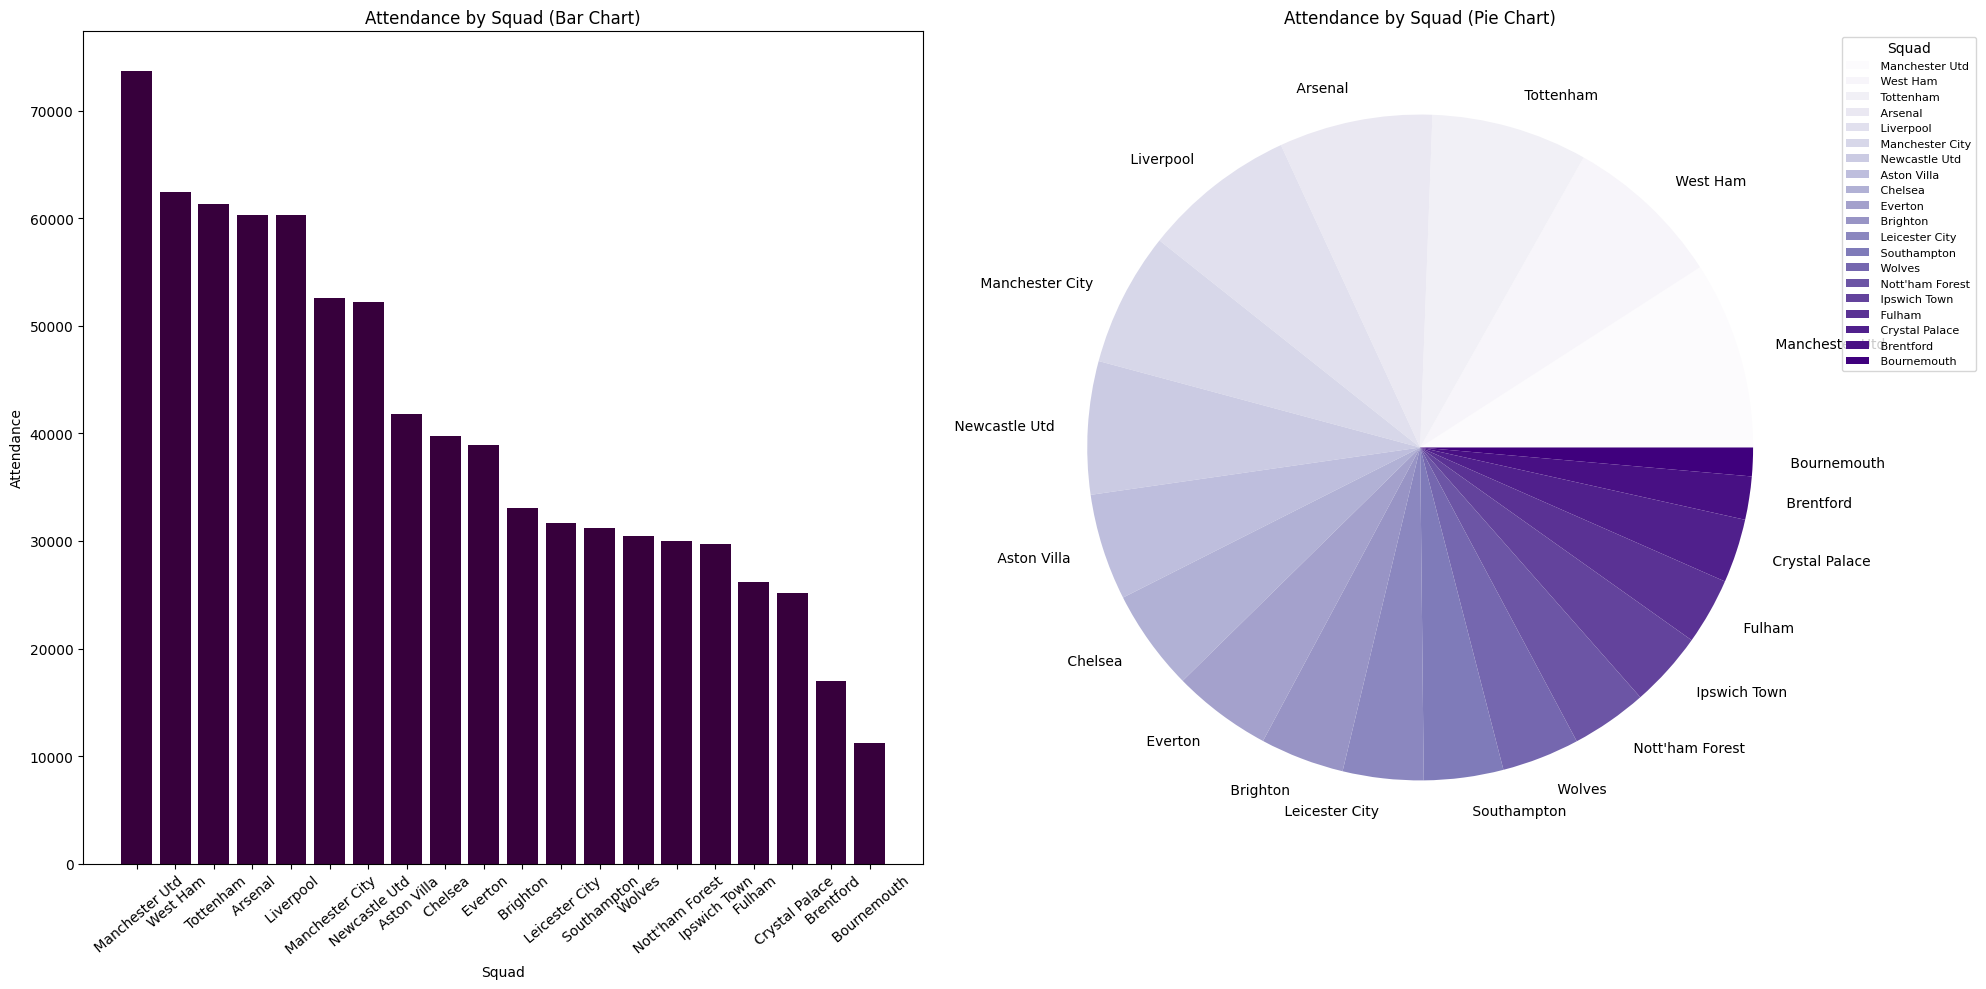

In [17]:

# Create a subplot figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better layout

# Bar plot
axes[0].bar(sorted_table["Squad"], sorted_table["Attendance"], color="#37003C")
axes[0].set_title("Attendance by Squad (Bar Chart)")
axes[0].set_xlabel("Squad")
axes[0].set_ylabel("Attendance")
axes[0].tick_params(axis='x', rotation=40)  # Rotate x-ticks for better readability

# Pie chart
df[["Squad", "Attendance"]].sort_values(by="Attendance", ascending=False).set_index("Squad").plot(
    kind="pie",
    y="Attendance",
    ax=axes[1],  # Use the second subplot axis
    colormap="Purples",
    legend=False
)
axes[1].set_ylabel("")  # Remove y-axis label
axes[1].set_title("Attendance by Squad (Pie Chart)")

# Add a legend for the pie chart outside the plot
axes[1].legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    title="Squad",
    fontsize=8
)

# Adjust layout
plt.tight_layout()
plt.show()


In [18]:
# Define the path to the SQLite database file
prem_scores_fixtures_database_path  = 'prem_scores_fix.db'

# Establish a connection to the SQLite database
# If the database does not exist, it will be created automatically
prem_scores_fixtures_database_connection = sqlite3.connect(prem_scores_fixtures_database_path)

database_tables = get_database_tables(prem_scores_fixtures_database_path)

# Display database table information
print("List of tables:", database_tables, "\n", "Number of tables:", len(database_tables))

# Iterate through each table in the database
for table_name in database_tables:
    # Retrieve all data from the current table
    table_dataframe = pd.read_sql_query(f"SELECT * FROM {table_name}", prem_scores_fixtures_database_connection)
    
    # Print the number of rows in the current table
    print(f"{table_name} contains {table_dataframe.shape} rows")

# load the data from the database into a pandas dataframe
fixture_data = pd.read_sql_query(f"SELECT * FROM s_f_sched_2024_2025_9_1", prem_scores_fixtures_database_connection)

# Close the database connection
prem_scores_fixtures_database_connection.close()

List of tables: ['s_f_sched_2024_2025_9_1'] 
 Number of tables: 1
s_f_sched_2024_2025_9_1 contains (417, 14) rows


In [20]:
# get info about the data
print(fixture_data.columns)
print(fixture_data.shape)
print(fixture_data.info())

Index(['Wk', 'Day', 'Date', 'Time', 'Home', 'xG', 'Score', 'xG - 2', 'Away',
       'Attendance', 'Venue', 'Referee', 'Match Report', 'Notes'],
      dtype='object')
(417, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Wk            417 non-null    object
 1   Day           417 non-null    object
 2   Date          417 non-null    object
 3   Time          417 non-null    object
 4   Home          417 non-null    object
 5   xG            417 non-null    object
 6   Score         417 non-null    object
 7   xG - 2        417 non-null    object
 8   Away          417 non-null    object
 9   Attendance    417 non-null    object
 10  Venue         417 non-null    object
 11  Referee       417 non-null    object
 12  Match Report  417 non-null    object
 13  Notes         417 non-null    object
dtypes: object(14)
memory usage: 45.7+ KB
None


In [21]:
# Replace empty strings with NaN
fixture_data = fixture_data[fixture_data['Away'] != ""].reset_index(drop=True).replace("", np.nan)

In [22]:
# Verify changes
fixture_data.shape

(380, 14)

In [23]:
# Show the column names with their respective index
print([(i, e)for i, e in enumerate(fixture_data.columns.to_list())])

[(0, 'Wk'), (1, 'Day'), (2, 'Date'), (3, 'Time'), (4, 'Home'), (5, 'xG'), (6, 'Score'), (7, 'xG - 2'), (8, 'Away'), (9, 'Attendance'), (10, 'Venue'), (11, 'Referee'), (12, 'Match Report'), (13, 'Notes')]


In [24]:
# Convert columns to the correct type
integer_cols = [0]
float_cols = [5, 7]
fixture_data = convert_columns(fixture_data,  integer_cols, float_cols)

In [25]:
# extract referee data
referee_data = fixture_data[fixture_data["Referee"] != ""]["Referee"].value_counts(dropna=True).to_frame(name="Games_refereed").reset_index()

In [26]:
# Confirm that the data was loaded correctly
referee_data.head()

,Referee,Games_refereed
0,Anthony Taylor,13
1,Michael Oliver,12
2,Robert Jones,10
3,Chris Kavanagh,10
4,Stuart Attwell,9


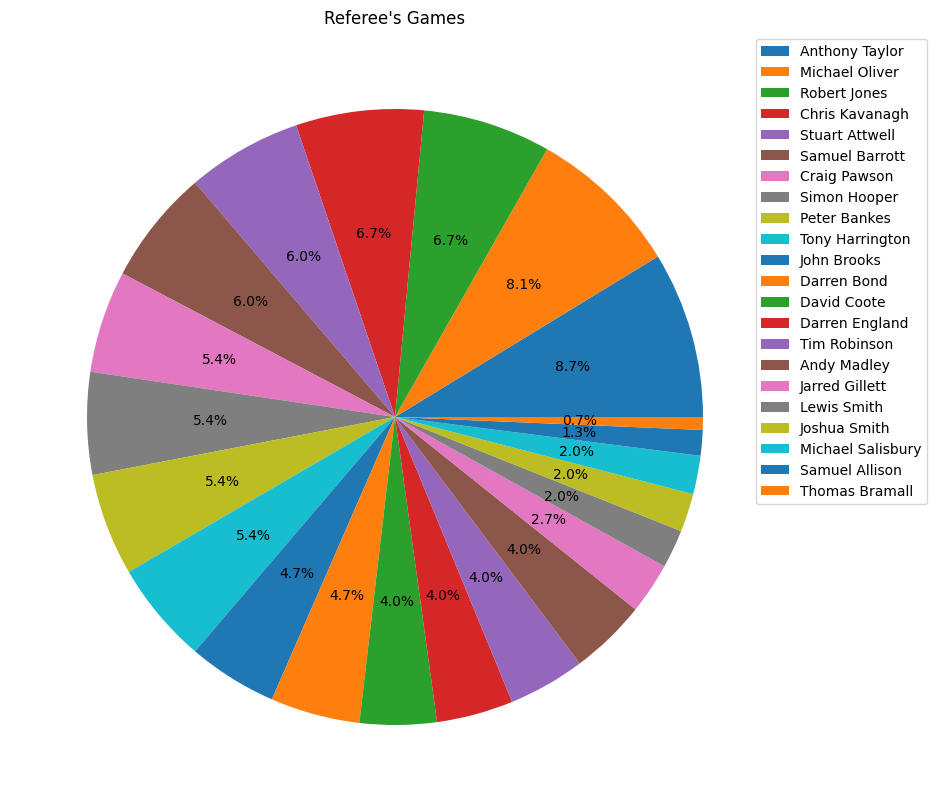

In [27]:
# Visualization of the percentage of games refereed by referees
plt.figure(figsize=(10, 10))
plt.pie(referee_data["Games_refereed"],autopct='%1.1f%%')
plt.title("Referee's Games")
plt.legend( loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1, fancybox=True, labels=referee_data["Referee"])
plt.show()

In [28]:
# extract past games from fixture data
past_games = fixture_data[fixture_data["Score"].notnull()]

In [29]:
def outcome(score: Tuple[int, int]) -> str:
    """
    Determine the outcome of a match based on the given scores.

    Parameters:
        score (Tuple[int, int]): A tuple where the first element is the home team's score
                                 and the second element is the away team's score.

    Returns:
        str: A string representing the match outcome, which can be:
             - "Draw" if both scores are equal
             - "Home Win" if the home team's score is greater
             - "Away Win" if the away team's score is greater
    """
    # Check if the scores are equal, indicating a draw
    if score[0] == score[1]:
        return "Draw"
    
    # Check if the home team's score is higher, indicating a home team win
    elif score[0] > score[1]:
        return "Home Win"
    
    # If the away team's score is higher, it indicates an away team win
    elif score[0] < score[1]:
        return "Away Win"

In [30]:
# extract score list from past_games
score_list = past_games["Score"].apply(lambda x: list(map(int,x.replace("–", " ").split(" "))))

In [34]:
# add a column for the outcome of the game
past_games.loc[:, "Outcome"] = [outcome(score) for score in score_list]

In [35]:
# Group the DataFrame by 'Referee' and 'Outcome', count the occurrences of each group,
# sort the counts in descending order, convert the result to a DataFrame,
# rename the 'Outcome' column to 'Count', reset the index, and extract the top 10 rows.
past_games.groupby(["Referee", "Outcome"])["Outcome"].count().sort_values(ascending=False).to_frame().rename(columns={"Outcome":"Count"}).reset_index().head(10)

,Referee,Outcome,Count
0,Anthony Taylor,Away Win,8
1,Darren Bond,Home Win,6
2,Peter Bankes,Home Win,6
3,Chris Kavanagh,Draw,6
4,Tony Harrington,Home Win,5
5,Robert Jones,Draw,5
6,John Brooks,Home Win,5
7,Samuel Barrott,Home Win,5
8,Michael Oliver,Draw,4
9,Michael Oliver,Away Win,4


In [36]:
# Group the DataFrame by 'Referee' and 'Home', count the occurrences of each group,
# convert the result to a DataFrame, rename the 'Home' column to 'Count',
# reset the index, and sort the rows by 'Count' in descending order.
past_games.groupby(["Referee", "Home"])["Home"].count().to_frame().rename(columns={"Home":"Count"}).reset_index().sort_values(by="Count", ascending=False)

,Referee,Home,Count
69,Michael Oliver,Bournemouth,2
13,Anthony Taylor,Tottenham,2
99,Samuel Barrott,Brighton,2
101,Samuel Barrott,Southampton,2
93,Robert Jones,Manchester Utd,2
...,...,...,...
42,Darren England,Manchester Utd,1
41,Darren England,Leicester City,1
40,Darren England,Fulham,1
39,Darren England,Crystal Palace,1
